In [2]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from datetime import datetime

jj = pd.read_csv('data/jj.csv')
jj.columns = ['date', 'eps']
jj.head()

,date,eps
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


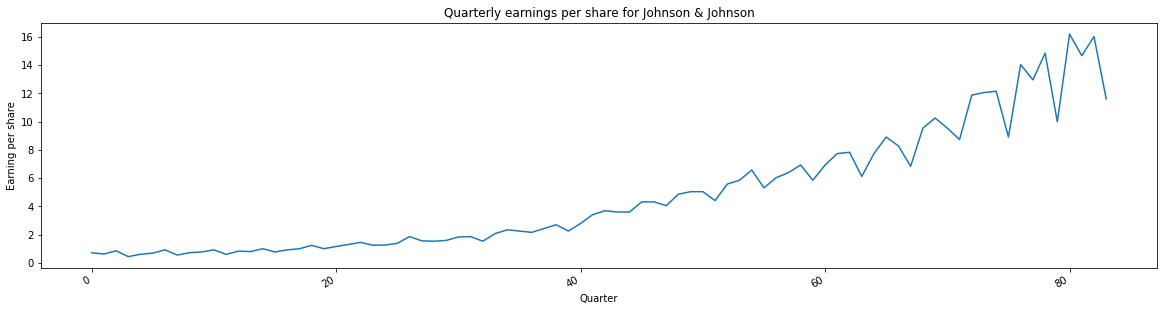

In [51]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(jj.eps)
ax.set_ylabel('Earning per share')
ax.set_xlabel('Quarter')

fig.autofmt_xdate()
plt.title('Quarterly earnings per share for Johnson & Johnson')
plt.show()

### 1 Use time series decomposition to identify the presence of a periodic pattern.

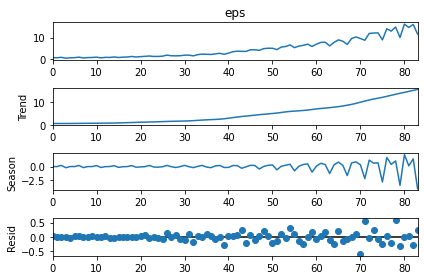

In [52]:
seasonal_decompose = STL(jj['eps'], period=4).fit()
seasonal_decompose.plot();

### 2 Use the optimize_SARIMA function and select the model with the lowest AIC.

In [53]:
# get the amount of differing to make a stationary timeseries
d = 0
data_to_test_adf = jj['eps'].copy()
while (True):
    adf_test = adfuller(data_to_test_adf, maxlag=30)
    print(adf_test)
    if adf_test[1] < 0.05:
        break
    else: 
        data_to_test_adf = np.diff(data_to_test_adf, n=1)
        d = d + 1

del data_to_test_adf
print(d)

(1.7603474964296995, 0.9982670434796656, 20, 63, {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}, 71.45949064106955)
(1.522371425754036, 0.9976049427108203, 30, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 54.21887733766343)
(-3.6486239369269664, 0.004896664111966153, 29, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 51.280808989276366)
2


In [54]:
data_to_test_adf = jj['eps'].copy()
data_to_test_adf = np.diff(data_to_test_adf, n=4)
adf_test = adfuller(data_to_test_adf, maxlag=30)
print(adf_test)
data_to_test_adf = np.diff(data_to_test_adf, n=4)
adf_test = adfuller(data_to_test_adf, maxlag=30)
print(adf_test)
D = 2

(-1.2320305094802544, 0.6596675018579465, 30, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 74.27683380531903)
(-3.4553767054100315, 0.009209855465073037, 28, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 106.85644220442964)


In [55]:
def optimize_SARIMAX(data: pd.Series, p_max : int = 4, q_max : int = 4, 
                    seasonal_p_max : int = 4, seasonal_q_max : int = 4, 
                    d : int = 1, D : int = 1,
                    s :int = 1) -> pd.DataFrame :
    ps = range(0, p_max)
    qs = range(0, q_max)
    Ps = range(0, seasonal_p_max) if seasonal_p_max > 1 else range(0,1)
    Qs = range(0, seasonal_q_max) if seasonal_q_max > 1 else range(0,1)
    
    combinations = product(ps, qs, Ps, Qs)
    buffer = []
    for order in combinations:
        try:
            sarimax_model = SARIMAX(data,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)
            ).fit(disp=False)

            buffer.append([order, sarimax_model.aic, sarimax_model.sse])
        except:
            pass
        
    result_df = pd.DataFrame(buffer, columns=['(p,q,P,Q)', 'aic', 'sse'])
    result_df.sort_values(by=['aic'], inplace=True)
    
    return result_df

In [56]:
train = jj.iloc[:-4]
test = jj.iloc[-4:]

model_search_df = optimize_SARIMAX(train['eps'], d=2, D=2, s=4)
model_search_df.iloc[:10]

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Michael_Enudi

,"(p,q,P,Q)",aic,sse
250,"(3, 3, 2, 2)",101.758110,12.608874
218,"(3, 1, 2, 2)",102.063635,13.446832
215,"(3, 1, 1, 3)",102.592891,13.450162
122,"(1, 3, 2, 2)",102.623183,13.552005
186,"(2, 3, 2, 2)",103.174782,13.292269
234,"(3, 2, 2, 2)",103.268038,13.351458
251,"(3, 3, 2, 3)",103.424698,12.589717
119,"(1, 3, 1, 3)",103.452526,13.713070
254,"(3, 3, 3, 2)",103.459944,12.626685
255,"(3, 3, 3, 3)",103.736838,11.974442


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


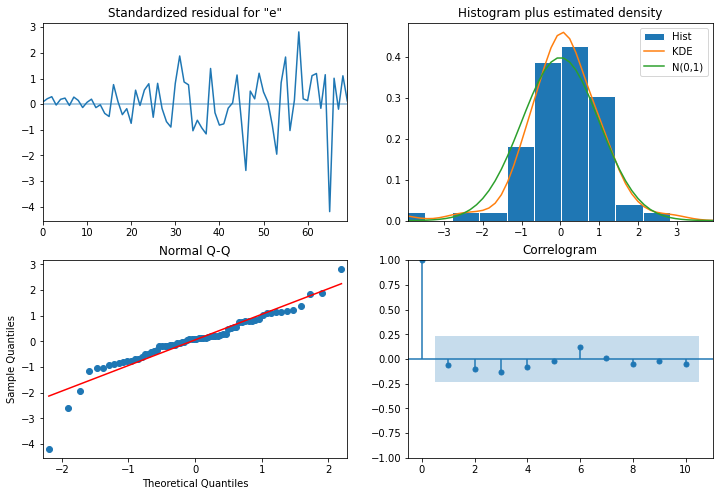

In [71]:
arima_order = (3, d, 3)
seasonal_order = (2, D, 2, 4)

sarimax = SARIMAX(train.eps,
                order=arima_order,
                seasonal_order=seasonal_order
            ).fit(disp=False)
sarimax.plot_diagnostics(figsize=(12, 8));

In [70]:
acorr_ljungbox(sarimax.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,1.441005,0.229977
2,1.719944,0.423174
3,3.213101,0.359922
4,4.789444,0.309592
5,5.178645,0.394470
6,5.583073,0.471474
7,5.842830,0.558217
8,6.127802,0.632919
9,6.270639,0.712556
10,6.353601,0.784732


In [72]:
test['sarima_pred'] = sarimax.get_prediction(80, 84).predicted_mean;